In [2]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import collections
import asyncio
import getpass
import re
from datetime import datetime as dt
import os,sys,re
import urllib3
import prettytable
from collections import Counter
import seaborn as sns
import random

from scipy.special import expit
from numpy import exp
import matplotlib.patches as patches



from sklearn.externals.joblib import Memory
memory = Memory(cachedir='/tmp', verbose=0)
#@memory.cache above any def fxn.

%matplotlib inline
plt.style.use('ggplot')

from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1024,
        'height': 768,
        'scroll': True,
})

%load_ext autotime

/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [ ]:
# note, all server information is stored in a config.py file that is present in the .gitignore
import importlib
scriptName = 'config.py'
script = importlib.import_module(wd+'/notebooks/PIPELINE/%s' % scriptName)

#import config
conn = psycopg2.connect(dbname=config.dbname, user=config.user, host=config.host, port=config.port,password=config.password)
cur=conn.cursor()

query_schema = 'SET search_path to ' + "mimiciii" + ';'

In [2]:
#importing clinical variable csv
#lab = f'data/interim/{today}-winemag_priceGBP.csv'

#/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/notebooks
final_pt_df2 = pd.read_csv('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/raw/csv/06072018_final_pt_df2.csv', index_col=0)
vaso_df = pd.read_csv('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/raw/csv/10072018_vaso_all_df.csv', index_col=0)


labs_all48=  pd.read_csv('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/wrangled/labs_all48_df.csv', index_col=0)
labs_all48= labs_all48[labs_all48['label'].notnull()] #labs_all48 has some rows with null label... this removes them.

bg_all48=  pd.read_csv('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/wrangled/labs_all48_df.csv', index_col=0)
vital_all48=  pd.read_csv('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/wrangled/vital_all48_df.csv', index_col=0)
cohort_df = pd.read_csv('/Users/geickelb1/Desktop/PhD_Misc/HSIP_442_Yuan_Lao/final_pt_df2_5-04-18.csv', index_col=0)
#final_pt_df2 = pd.read_csv('/Users/geickelb1/Desktop/PhD_Misc/HSIP_442_Yuan_Lao/final_pt_df2_5-04-18.csv', index_col=0)



/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


time: 12.6 s



 
 So, essentially, at the beginning, with little information, risk for infection is high (patient is sick in the ICU, infections are common) then as more clinical information is available, for those with no infection we hypothesize that we will be able to detect a decrease in probability of infection using that data (our central hypothesis).


<Figure size 432x288 with 0 Axes>

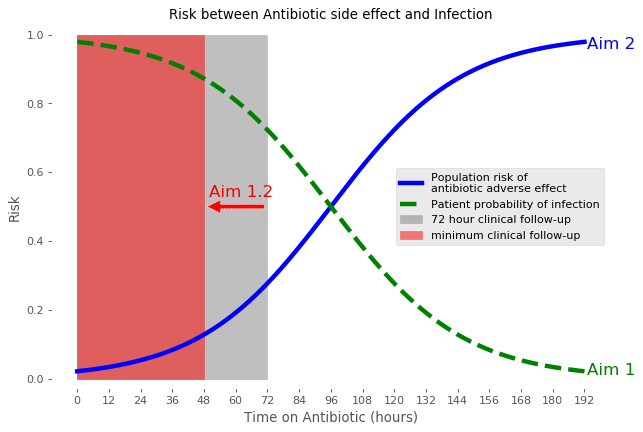

time: 759 ms


In [2]:
fig = plt.figure()
fig=plt.figure(figsize=(9, 6), dpi= 80, facecolor='w')
ax = plt.axes()

###line parameters and plots
x = np.linspace(0, 192, 1000)
xt=96 #midpoint of the curev
k=0.04 #slope of the curve
L=1 # max y value
ax.plot(x,
        (L/(1+exp(-k*(x-xt)))),
        linestyle='-',
        linewidth=4.0,
        color='blue'
       )
ax.plot(x,
        1-(L/(1+exp(-k*(x-xt)))),
        linestyle='--',
        linewidth=4.0,
        color='green'
       )

#ax.plot(x, 1-(L/(1+exp(-k*(x-75)))), linestyle='--')
#ax.plot(x, 1-(L/(1+exp(-0.03*(x-150)))), linestyle='--')
#ax.plot(x, 1-(L/(1+exp(-k*(x-75)))), linestyle='--')
#ax.plot([72, 72], [0, 1], color='black', linestyle=':', linewidth=2) #og clinical time
#ax.plot([48, 48], [0, 1], color='red', linestyle=':', linewidth=2) #reduced clinical time

###annotations
ax.annotate('',
            xy=(72-24, 0.5),
            xytext=(92-20, 0.5),
            arrowprops=dict(facecolor='red',
            shrink=0.05,
            linestyle='--'),
            )

ax.annotate('Aim 1',
            xy=(183, 0.01),
            xytext=(193, 0.01),
            color='green',
            size=15
            )
# ax.annotate('Aim 1.2',
#             xy=(62, 0.49),
#             xytext=(72, 0.49),
#             color='red',
#             size=15,
#             )
ax.annotate('Aim 1.2',
            xy=(40, 0.53),
            xytext=(50, 0.53),
            color='red',
            size=15,
            )

ax.annotate('Aim 2',
            xy=(183, 0.96),
            xytext=(193, 0.96),
            color='blue',
            size=15,
            )

###rectangles
p = patches.Rectangle(
    ([0,0]), 72, 1, fill=True, alpha=.5, color='grey', hatch='')#, fill=False, clip_on=False)
#Rectangle(xy, width, height, angle=0.0, **kwargs)[source]
ax.add_patch(p) #adds grey rectangle
p = patches.Rectangle(
    ([0,0]), 48, 1, fill=True,alpha=.5, color='red', hatch='')#, fill=False, clip_on=False)
#Rectangle(xy, width, height, angle=0.0, **kwargs)[source]
ax.add_patch(p)

###legend
ax.legend((
    'Population risk of \nantibiotic adverse effect',
    'Patient probability of infection',
    '72 hour clinical follow-up',
    'minimum clinical follow-up'),
    loc= 'best', fontsize='medium')
ax.set_facecolor('white')
###plot titles & axes
ax.set_ylabel('Risk', fontsize='large')
ax.set_xlabel('Time on Antibiotic (hours)', fontsize='large')
ax.set_title('Risk between Antibiotic side effect and Infection', fontsize='large')
plt.xticks(np.arange(min(x), max(x)+1, 12))




So, essentially, at the beginning, with little information, risk for infection is high (patient is sick in the ICU, infections are common) then as more clinical information is available, for those with no infection we hypothesize that we will be able to detect a decrease in probability of infection using that data (our central hypothesis)."


([<matplotlib.axis.XTick at 0x125ae6470>,
 <a list of 17 Text xticklabel objects>)

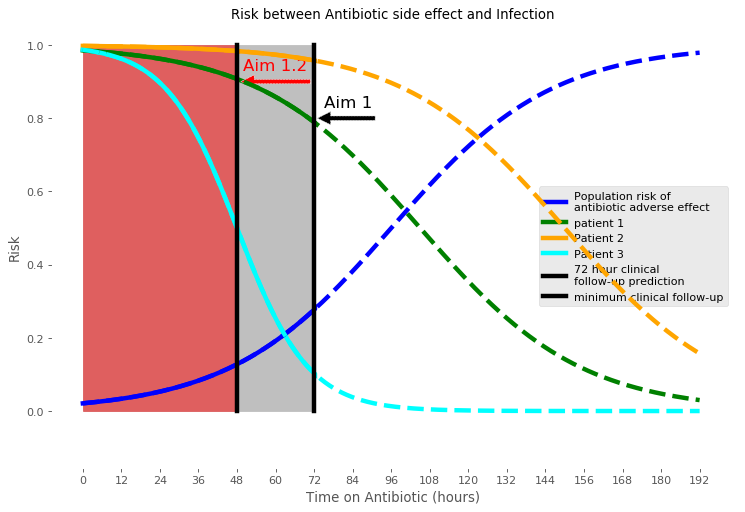

time: 573 ms


In [157]:
# fig = plt.figure()
size=11
fig = plt.figure(figsize=(size, size*(2/3)), dpi= 80, facecolor='w')
ax = plt.axes()

###line parameters and plots
x = np.linspace(0, 192, 1000)
xt=96 #midpoint of the curev
k=0.04 #slope of the curve
L=1 # max y value

ax.plot(x,
        (L/(1+exp(-k*(x-xt)))),
        linestyle='-',
        linewidth=4.0,
        color='blue'
       )
ax.plot(x,
        1-(L/(1+exp(-k*(x-105)))),
        linestyle='-',
        linewidth=4.0,
        color='green'
       )

ax.plot(x,
        1-(L/(1+exp(-k*(x-150)))),
        linestyle='-',
        linewidth=4.0,
        color='orange'
       )

ax.plot(x,
        1-(L/(1+exp(-0.09*(x-48)))),
        linestyle='-',
        linewidth=4.0,
        color='cyan'
       )


ax.plot([72, 72], [0, 1], color='black', linestyle='-', linewidth=4, zorder=40) #origional clinical time
ax.plot([48, 48], [0, 1], color='black', linestyle='-', linewidth=4, zorder=40) #reduced clinical time

###annotations
ax.annotate('',
            xy=(72, 0.5+0.3),
            xytext=(92, 0.5+0.3),
            arrowprops=dict(facecolor='black',
            shrink=0.05,
            linestyle='--'),
            )

ax.annotate('Aim 1',
            xy=(62, 0.53+0.3),
            xytext=(75, 0.53+0.3),
            color='black',
            size=15,
            )

ax.annotate('',
            xy=(72-24, 0.5+0.4),
            xytext=(92-20, 0.5+0.4),
            arrowprops=dict(facecolor='red',
            shrink=0.05,
            linestyle='--'),
            )

ax.annotate('Aim 1.2',
            xy=(40, 0.53+0.4),
            xytext=(50, 0.53+0.4),
            color='red',
            size=15,
            )


###rectangles
#Rectangle(xy, width, height, angle=0.0, **kwargs)[source]
p1 = patches.Rectangle(
    ([0,0]), 72, 1, fill=True, alpha=.5, color='grey', hatch='', zorder=1)
p2 = patches.Rectangle(
    ([0,0]), 48, 1, fill=True,alpha=.5, color='red', hatch='',zorder=1)#, fill=False, clip_on=False)
#white rectangle to plot over
p3 = patches.Rectangle(([73,-0.1]), 120, 1.1, fill=True, alpha=1, color='white', zorder=3)
# p4 = patches.Rectangle(([73,0]), 120, 0.28, fill=True, alpha=0.5, color='blue', hatch='', zorder=4)



ax.add_patch(p1)
ax.add_patch(p2)
ax.add_patch(p3)
# ax.add_patch(p4)

#post prediction lines
# ax.plot([72, 192], [0.1, 0.1], color='cyan', linestyle='--', linewidth=4, zorder=100)
# ax.plot([72, 192], [0.28, 0.28], color='blue', linestyle='-', linewidth=4, zorder=100)
# ax.plot([72, 192], [0.8, 0.8], color='green', linestyle='--', linewidth=4, zorder=100)
# ax.plot([72, 192], [0.96, 0.96], color='orange', linestyle='--', linewidth=4, zorder=100)

ax.plot(x,
        (L/(1+exp(-k*(x-xt)))),
        linestyle='--',
        linewidth=4.0,
        color='blue', zorder=10
       )
ax.plot(x,
        1-(L/(1+exp(-k*(x-105)))),
        linestyle='--',
        linewidth=4.0,
        color='green', zorder=10
       )

ax.plot(x,
        1-(L/(1+exp(-k*(x-150)))),
        linestyle='--',
        linewidth=4.0,
        color='orange', zorder=10
       )

ax.plot(x,
        1-(L/(1+exp(-0.09*(x-48)))),
        linestyle='--',
        linewidth=4.0,
        color='cyan', zorder=10)
       

###legend
ax.set_zorder(600)
ax.legend((
    'Population risk of \nantibiotic adverse effect',
    'patient 1',
    'Patient 2',
    'Patient 3',
    '72 hour clinical \nfollow-up prediction',
    'minimum clinical follow-up'),
    loc= 'center right', fontsize='medium')
ax.set_zorder(600)
ax.set_facecolor('white')
###plot titles & axes
ax.set_ylabel('Risk', fontsize='large')
ax.set_xlabel('Time on Antibiotic (hours)', fontsize='large')
ax.set_title('Risk between Antibiotic side effect and Infection', fontsize='large')
plt.xticks(np.arange(min(x), max(x)+1, 12))



swap dashed and solid line for population/pt. 

note that we are only observing the play out of the competing factors

([<matplotlib.axis.XTick at 0x122af2d68>,
 <a list of 17 Text xticklabel objects>)

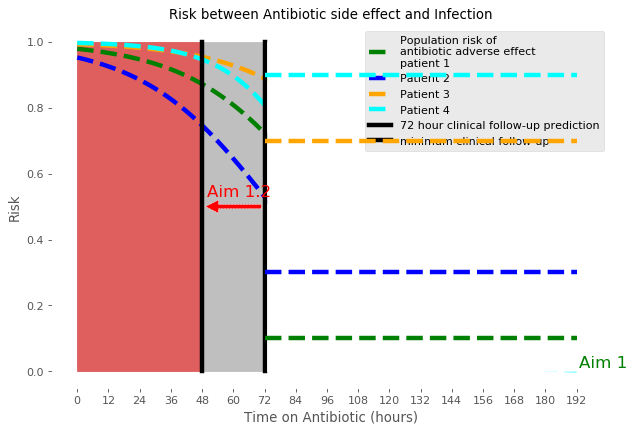

time: 491 ms


In [135]:
# fig = plt.figure()
fig=plt.figure(figsize=(9, 6), dpi= 80, facecolor='w')
ax = plt.axes()

###line parameters and plots
x = np.linspace(0, 192, 1000)
xt=96 #midpoint of the curev
k=0.04 #slope of the curve
L=1 # max y value

ax.plot(x,
        1-(L/(1+exp(-k*(x-xt)))),
        linestyle='--',
        linewidth=4.0,
        color='green'
       )

ax.plot(x,
        1-(L/(1+exp(-k*(x-75)))),
        linestyle='--',
        linewidth=4.0,
        color='blue'
       )

ax.plot(x,
        1-(L/(1+exp(-k*(x-124)))),
        linestyle='--',
        linewidth=4.0,
        color='orange'
       )

ax.plot(x,
        1-(L/(1+exp(-0.06*(x-xt)))),
        linestyle='--',
        linewidth=4.0,
        color='cyan'
       )


ax.plot([72, 72], [0, 1], color='black', linestyle='-', linewidth=4) #origional clinical time
ax.plot([48, 48], [0, 1], color='black', linestyle='-', linewidth=4) #reduced clinical time

###annotations
ax.annotate('',
            xy=(72-24, 0.5),
            xytext=(92-20, 0.5),
            arrowprops=dict(facecolor='red',
            shrink=0.05,
            linestyle='--'),
            )

ax.annotate('Aim 1',
            xy=(183, 0.01),
            xytext=(193, 0.01),
            color='green',
            size=15
            )

ax.annotate('Aim 1.2',
            xy=(40, 0.53),
            xytext=(50, 0.53),
            color='red',
            size=15,
            )


###rectangles
#Rectangle(xy, width, height, angle=0.0, **kwargs)[source]
p1 = patches.Rectangle(
    ([0,0]), 72, 1, fill=True, alpha=.5, color='grey', hatch='', zorder=1)
p2 = patches.Rectangle(
    ([0,0]), 48, 1, fill=True,alpha=.5, color='red', hatch='',zorder=1)#, fill=False, clip_on=False)
#white rectangle to plot over
p3 = patches.Rectangle(([73,0]), 122, 1, fill=True,alpha=1, color='white', zorder=3)

ax.add_patch(p1)
ax.add_patch(p2)
ax.add_patch(p3)


#post prediction lines
ax.plot([72, 192], [0.1, 0.1], color='green', linestyle='--', linewidth=4, zorder=100)
ax.plot([72, 192], [0.3, 0.3], color='blue', linestyle='--', linewidth=4, zorder=100)
ax.plot([72, 192], [0.7, 0.7], color='orange', linestyle='--', linewidth=4, zorder=100)
ax.plot([72, 192], [0.9, 0.9], color='cyan', linestyle='--', linewidth=4, zorder=100)


###legend
ax.set_zorder(6)
ax.legend((
    'Population risk of \nantibiotic adverse effect \npatient 1',
    'Patient 2',
    'Patient 3',
    'Patient 4',
    '72 hour clinical follow-up prediction',
    'minimum clinical follow-up'),
    loc= 'best', fontsize='medium')
ax.set_zorder(23)
ax.set_facecolor('white')
###plot titles & axes
ax.set_ylabel('Risk', fontsize='large')
ax.set_xlabel('Time on Antibiotic (hours)', fontsize='large')
ax.set_title('Risk between Antibiotic side effect and Infection', fontsize='large')
plt.xticks(np.arange(min(x), max(x)+1, 12))



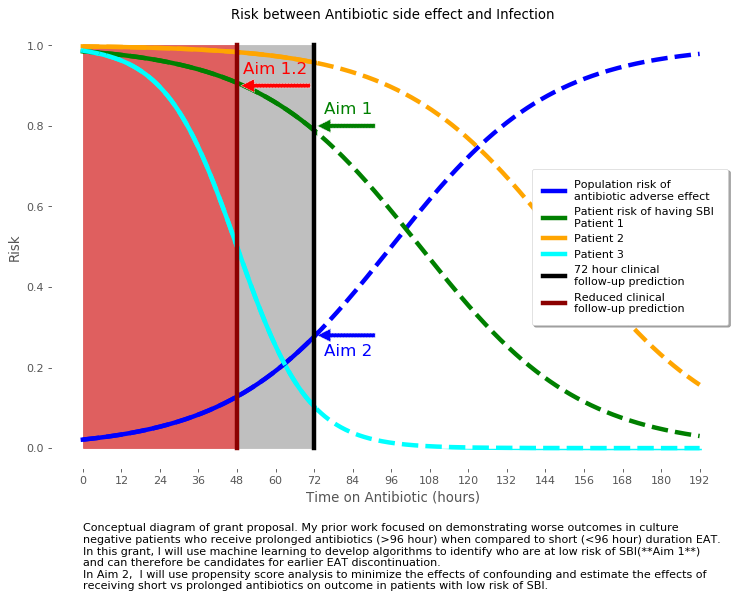

time: 800 ms


In [227]:
# fig = plt.figure()
size=11
fig=plt.figure(figsize=(size, size*(2/3)), dpi= 80, facecolor='w')
ax = plt.axes()

###line parameters and plots
x = np.linspace(0, 192, 1000)
xt=96 #midpoint of the curev
k=0.04 #slope of the curve
L=1 # max y value

ax.plot(x,
        (L/(1+exp(-k*(x-xt)))),
        linestyle='-',
        linewidth=4.0,
        color='blue'
       )
ax.plot(x,
        1-(L/(1+exp(-k*(x-105)))),
        linestyle='-',
        linewidth=4.0,
        color='green'
       )

ax.plot(x,
        1-(L/(1+exp(-k*(x-150)))),
        linestyle='-',
        linewidth=4.0,
        color='orange'
       )

ax.plot(x,
        1-(L/(1+exp(-0.09*(x-48)))),
        linestyle='-',
        linewidth=4.0,
        color='cyan'
       )


ax.plot([72, 72], [0, 1], color='black', linestyle='-', linewidth=4, zorder=40) #origional clinical time
ax.plot([48, 48], [0, 1], color='darkred', linestyle='-', linewidth=4, zorder=40) #reduced clinical time

###annotations
ax.annotate('',
            xy=(72, 0.5+0.3),
            xytext=(92, 0.5+0.3),
            arrowprops=dict(facecolor='green',
            shrink=0.05,
            linestyle='--'),
            )

ax.annotate('Aim 1',
            xy=(62, 0.53+0.3),
            xytext=(75, 0.53+0.3),
            color='green',
            size=15,
            )

ax.annotate('',
            xy=(72-24, 0.5+0.4),
            xytext=(92-20, 0.5+0.4),
            arrowprops=dict(facecolor='red',
            shrink=0.05,
            linestyle='--'), zorder=10
            )

ax.annotate('Aim 1.2',
            xy=(40, 0.53+0.4),
            xytext=(50, 0.53+0.4),
            color='red',
            size=15, zorder=10
            )

ax.annotate('',
            xy=(72, 0.5-0.22),
            xytext=(92, 0.5-0.22),
            arrowprops=dict(facecolor='blue',
            shrink=0.05,
            linestyle='--'),
            )

ax.annotate('Aim 2',
            xy=(62, 0.53-0.3),
            xytext=(75, 0.53-0.3),
            color='blue',
            size=15,
            )




###rectangles
#Rectangle(xy, width, height, angle=0.0, **kwargs)[source]
p1 = patches.Rectangle(
    ([0,0]), 72, 1, fill=True, alpha=.5, color='grey', hatch='', zorder=1)
p2 = patches.Rectangle(
    ([0,0]), 48, 1, fill=True,alpha=.5, color='red', hatch='',zorder=1)#, fill=False, clip_on=False)
#white rectangle to plot over
p3 = patches.Rectangle(([73,0]), 120, 1, fill=True, alpha=1, color='white', zorder=3)

ax.add_patch(p1)
ax.add_patch(p2)
ax.add_patch(p3)

###dotted plots
ax.plot(x,
        (L/(1+exp(-k*(x-xt)))),
        linestyle='--',
        linewidth=4.0,
        color='blue', zorder=7
       )
ax.plot(x,
        1-(L/(1+exp(-k*(x-105)))),
        linestyle='--',
        linewidth=4.0,
        color='green', zorder=7
       )

ax.plot(x,
        1-(L/(1+exp(-k*(x-150)))),
        linestyle='--',
        linewidth=4.0,
        color='orange', zorder=5
       )

ax.plot(x,
        1-(L/(1+exp(-0.09*(x-48)))),
        linestyle='--',
        linewidth=4.0,
        color='cyan', zorder=7)
       

###legend
ax.set_zorder(8)
ax.legend((
    'Population risk of \nantibiotic adverse effect',
    'Patient risk of having SBI \nPatient 1',
    'Patient 2',
    'Patient 3',
    '72 hour clinical \nfollow-up prediction',
    'Reduced clinical \nfollow-up prediction'),
    loc= 'center right', fontsize='medium', framealpha= 1, fancybox=True, facecolor='white',shadow=True, borderpad=1, frameon=True)
ax.set_zorder(8)
ax.set_facecolor('white')
###plot titles & axes
ax.set_ylabel('Risk', fontsize='large')
ax.set_xlabel('Time on Antibiotic (hours)', fontsize='large')
ax.set_title('Risk between Antibiotic side effect and Infection', fontsize='large')
plt.xticks(np.arange(min(x), max(x)+1, 12))

# center text

ax.text(0, -0.35, txt, ha='left')


plt.savefig('../figures/01082018_Spec_aim_figure1')
plt.show()


In [4]:
# figure as of final grant turnin, 8/21/18. with axes and titles and text under the graph being edited in word/powerpoint.

time: 47.9 ms


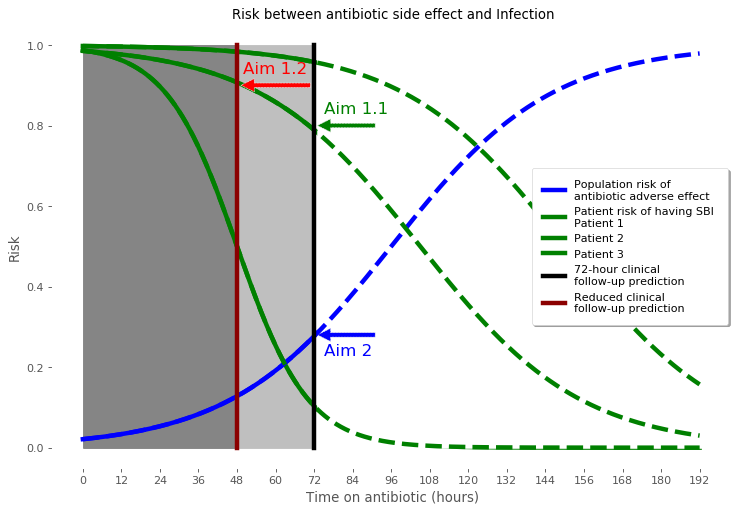

time: 873 ms


In [8]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

# fig = plt.figure()
size=11
fig=plt.figure(figsize=(size, size*(2/3)), dpi= 80, facecolor='w')
ax = plt.axes()

###line parameters and plots
x = np.linspace(0, 192, 1000)
xt=96 #midpoint of the curev
k=0.04 #slope of the curve
L=1 # max y value

ax.plot(x,
        (L/(1+exp(-k*(x-xt)))),
        linestyle='-',
        linewidth=4.0,
        color='blue'
       )
ax.plot(x,
        1-(L/(1+exp(-k*(x-105)))),
        linestyle='-',
        linewidth=4.0,
        color='green'
       )

ax.plot(x,
        1-(L/(1+exp(-k*(x-150)))),
        linestyle='-',
        linewidth=4.0,
        color='green'
       )

ax.plot(x,
        1-(L/(1+exp(-0.09*(x-48)))),
        linestyle='-',
        linewidth=4.0,
        color='green'
       )


ax.plot([72, 72], [0, 1], color='black', linestyle='-', linewidth=4, zorder=40) #origional clinical time
ax.plot([48, 48], [0, 1], color='darkred', linestyle='-', linewidth=4, zorder=40) #reduced clinical time

###annotations
ax.annotate('',
            xy=(72, 0.5+0.3),
            xytext=(92, 0.5+0.3),
            arrowprops=dict(facecolor='green',
            shrink=0.05,
            linestyle='--'),
            )

ax.annotate('Aim 1.1',
            xy=(62, 0.53+0.3),
            xytext=(75, 0.53+0.3),
            color='green',
            size=15,
            )

ax.annotate('',
            xy=(72-24, 0.5+0.4),
            xytext=(92-20, 0.5+0.4),
            arrowprops=dict(facecolor='red',
            shrink=0.05,
            linestyle='--'), zorder=10
            )

ax.annotate('Aim 1.2',
            xy=(40, 0.53+0.4),
            xytext=(50, 0.53+0.4),
            color='red',
            size=15, zorder=10
            )

ax.annotate('',
            xy=(72, 0.5-0.22),
            xytext=(92, 0.5-0.22),
            arrowprops=dict(facecolor='blue',
            shrink=0.05,
            linestyle='--'),
            )

ax.annotate('Aim 2',
            xy=(62, 0.53-0.3),
            xytext=(75, 0.53-0.3),
            color='blue',
            size=15,
            )
###rectangles
#Rectangle(xy, width, height, angle=0.0, **kwargs)[source]
p1 = patches.Rectangle(
    ([0,0]), 72, 1, fill=True, alpha=.5, color='grey', hatch='', zorder=1)
p2 = patches.Rectangle(
    ([0,0]), 48, 1, fill=True,alpha=.3, color='black', hatch='',zorder=1)#, fill=False, clip_on=False)
#white rectangle to plot over
p3 = patches.Rectangle(([73,0]), 120, 1, fill=True, alpha=1, color='white', zorder=3)

ax.add_patch(p1)
ax.add_patch(p2)
ax.add_patch(p3)

###dotted plots
ax.plot(x,
        (L/(1+exp(-k*(x-xt)))),
        linestyle='--',
        linewidth=4.0,
        color='blue', zorder=7
       )
ax.plot(x,
        1-(L/(1+exp(-k*(x-105)))),
        linestyle='--',
        linewidth=4.0,
        color='green', zorder=7
       )

ax.plot(x,
        1-(L/(1+exp(-k*(x-150)))),
        linestyle='--',
        linewidth=4.0,
        color='green', zorder=5
       )

ax.plot(x,
        1-(L/(1+exp(-0.09*(x-48)))),
        linestyle='--',
        linewidth=4.0,
        color='green', zorder=7)
       

###legend
ax.set_zorder(8)
ax.legend((
    'Population risk of \nantibiotic adverse effect',
    'Patient risk of having SBI \nPatient 1',
    'Patient 2',
    'Patient 3',
    '72-hour clinical \nfollow-up prediction',
    'Reduced clinical \nfollow-up prediction'),
    loc= 'center right', fontsize='medium', framealpha= 1, fancybox=True, facecolor='white',shadow=True, borderpad=1, frameon=True)
ax.set_zorder(8)
ax.set_facecolor('white')
###plot titles & axes
ax.set_ylabel('Risk', fontsize='large')
ax.set_xlabel('Time on antibiotic (hours)', fontsize='large')
ax.set_title('Risk between antibiotic side effect and Infection', fontsize='large')
plt.xticks(np.arange(min(x), max(x)+1, 12))

# center text

date= '08212018'
plt.savefig('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling//figures/%s_Spec_aim_figure1' %(date))
plt.show()


# figure as of final grant turnin, 8/21/18. with annotations removed :

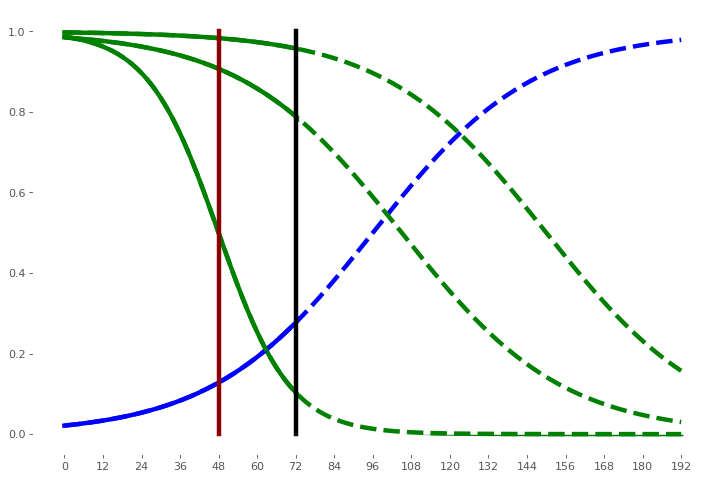

time: 444 ms


In [4]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

# fig = plt.figure()
size=11
fig=plt.figure(figsize=(size, size*(2/3)), dpi= 80, facecolor='w')
ax = plt.axes()

###line parameters and plots
x = np.linspace(0, 192, 1000)
xt=96 #midpoint of the curev
k=0.04 #slope of the curve
L=1 # max y value

ax.plot(x,
        (L/(1+exp(-k*(x-xt)))),
        linestyle='-',
        linewidth=4.0,
        color='blue'
       )
ax.plot(x,
        1-(L/(1+exp(-k*(x-105)))),
        linestyle='-',
        linewidth=4.0,
        color='green'
       )

ax.plot(x,
        1-(L/(1+exp(-k*(x-150)))),
        linestyle='-',
        linewidth=4.0,
        color='green'
       )

ax.plot(x,
        1-(L/(1+exp(-0.09*(x-48)))),
        linestyle='-',
        linewidth=4.0,
        color='green'
       )


ax.plot([72, 72], [0, 1], color='black', linestyle='-', linewidth=4, zorder=40) #origional clinical time
ax.plot([48, 48], [0, 1], color='darkred', linestyle='-', linewidth=4, zorder=40) #reduced clinical time

###rectangles
#Rectangle(xy, width, height, angle=0.0, **kwargs)[source]
p1 = patches.Rectangle(
    ([0,0]), 72, 1, fill=True, alpha=.5, color='grey', hatch='', zorder=1)
p2 = patches.Rectangle(
    ([0,0]), 48, 1, fill=True,alpha=.3, color='black', hatch='',zorder=1)#, fill=False, clip_on=False)
#white rectangle to plot over
p3 = patches.Rectangle(([73,0]), 120, 1, fill=True, alpha=1, color='white', zorder=3)

#ax.add_patch(p1)
#ax.add_patch(p2)
ax.add_patch(p3)

###dotted plots
ax.plot(x,
        (L/(1+exp(-k*(x-xt)))),
        linestyle='--',
        linewidth=4.0,
        color='blue', zorder=7
       )
ax.plot(x,
        1-(L/(1+exp(-k*(x-105)))),
        linestyle='--',
        linewidth=4.0,
        color='green', zorder=7
       )

ax.plot(x,
        1-(L/(1+exp(-k*(x-150)))),
        linestyle='--',
        linewidth=4.0,
        color='green', zorder=5
       )

ax.plot(x,
        1-(L/(1+exp(-0.09*(x-48)))),
        linestyle='--',
        linewidth=4.0,
        color='green', zorder=7)
       

###legend
ax.set_zorder(8)
ax.set_zorder(8)
ax.set_facecolor('white')
###plot titles & axes
#ax.set_ylabel('Risk', fontsize='large')
#ax.set_xlabel('Time on antibiotic (hours)', fontsize='large')
#ax.set_title('Risk between antibiotic side effect and Infection', fontsize='large')
plt.xticks(np.arange(min(x), max(x)+1, 12))

# center text


date= '08222018'
plt.savefig('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling//figures/%s_Spec_aim_figure1_noannotation' %(date))
plt.show()

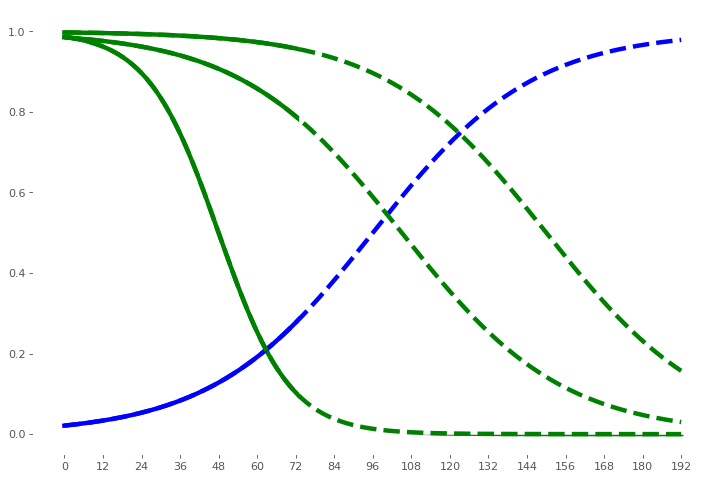

time: 427 ms


In [5]:
#removing red and black lines
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

# fig = plt.figure()
size=11
fig=plt.figure(figsize=(size, size*(2/3)), dpi= 80, facecolor='w')
ax = plt.axes()

###line parameters and plots
x = np.linspace(0, 192, 1000)
xt=96 #midpoint of the curev
k=0.04 #slope of the curve
L=1 # max y value

ax.plot(x,
        (L/(1+exp(-k*(x-xt)))),
        linestyle='-',
        linewidth=4.0,
        color='blue'
       )
ax.plot(x,
        1-(L/(1+exp(-k*(x-105)))),
        linestyle='-',
        linewidth=4.0,
        color='green'
       )

ax.plot(x,
        1-(L/(1+exp(-k*(x-150)))),
        linestyle='-',
        linewidth=4.0,
        color='green'
       )

ax.plot(x,
        1-(L/(1+exp(-0.09*(x-48)))),
        linestyle='-',
        linewidth=4.0,
        color='green'
       )


#ax.plot([72, 72], [0, 1], color='black', linestyle='-', linewidth=4, zorder=40) #origional clinical time
#ax.plot([48, 48], [0, 1], color='darkred', linestyle='-', linewidth=4, zorder=40) #reduced clinical time

###rectangles
#Rectangle(xy, width, height, angle=0.0, **kwargs)[source]
p1 = patches.Rectangle(
    ([0,0]), 72, 1, fill=True, alpha=.5, color='grey', hatch='', zorder=1)
p2 = patches.Rectangle(
    ([0,0]), 48, 1, fill=True,alpha=.3, color='black', hatch='',zorder=1)#, fill=False, clip_on=False)
#white rectangle to plot over
p3 = patches.Rectangle(([73,0]), 120, 1, fill=True, alpha=1, color='white', zorder=3)

#ax.add_patch(p1)
#ax.add_patch(p2)
ax.add_patch(p3)

###dotted plots
ax.plot(x,
        (L/(1+exp(-k*(x-xt)))),
        linestyle='--',
        linewidth=4.0,
        color='blue', zorder=7
       )
ax.plot(x,
        1-(L/(1+exp(-k*(x-105)))),
        linestyle='--',
        linewidth=4.0,
        color='green', zorder=7
       )

ax.plot(x,
        1-(L/(1+exp(-k*(x-150)))),
        linestyle='--',
        linewidth=4.0,
        color='green', zorder=5
       )

ax.plot(x,
        1-(L/(1+exp(-0.09*(x-48)))),
        linestyle='--',
        linewidth=4.0,
        color='green', zorder=7)
       

###legend
ax.set_zorder(8)
ax.set_zorder(8)
ax.set_facecolor('white')
###plot titles & axes
#ax.set_ylabel('Risk', fontsize='large')
#ax.set_xlabel('Time on antibiotic (hours)', fontsize='large')
#ax.set_title('Risk between antibiotic side effect and Infection', fontsize='large')
plt.xticks(np.arange(min(x), max(x)+1, 12))

# center text


date= '08222018'
plt.savefig('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling//figures/%s_Spec_aim_figure1_noannotation2' %(date))
plt.show()